## 1. Setup and Get Data (Python 3.10.11)

### 1.1 Install Dependencies and Setup

In [1]:
!pip install --default-timeout=1000 labelme tensorflow==2.8.0 tensorflow-gpu==2.8.0 opencv-python matplotlib albumentations

In [2]:
!pip install protobuf==3.20.0

In [3]:
!pip list

Package                      Version
---------------------------- -------------------
absl-py                      2.1.0
albumentations               1.4.4
annotated-types              0.6.0
asttokens                    2.4.1
astunparse                   1.6.3
beautifulsoup4               4.12.3
cachetools                   5.3.3
certifi                      2024.2.2
charset-normalizer           3.3.2
colorama                     0.4.6
coloredlogs                  15.0.1
comm                         0.2.2
contourpy                    1.2.1
cycler                       0.12.1
debugpy                      1.8.1
decorator                    5.1.1
exceptiongroup               1.2.1
executing                    2.0.1
filelock                     3.14.0
flatbuffers                  24.3.25
fonttools                    4.51.0
gast                         0.5.4
gdown                        5.1.0
google-auth                  2.29.0
google-auth-oauthlib         0.4.6
google-pasta                

### 1.2 Collect Image Using OpenCV

In [3]:
import os
import time
import uuid
import cv2

In [5]:
IMAGES_PATH = os.path.join("data", "images")
number_images = 30

In [6]:
cap = cv2.VideoCapture(0)

for imgnum in range(number_images):
    print("Collecting images {}".format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH, f"{str(uuid.uuid1())}.jpg")
    cv2.imwrite(imgname, frame)
    cv2.imshow("Frame", frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [7]:
!labelme

2024-05-01 22:16:52,636 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\agift\.labelmerc


## 2. Review Dataset and Build Image Loading Function

### 2.1 Import TensorFlow and Dependencies

In [8]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [9]:
gpus = tf.config.experimental.list_physical_devices("GPU")

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [10]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 2.3 Load Image into TensorFlow Data

In [11]:
images = tf.data.Dataset.list_files("data\\images\\*.jpg", shuffle=False)

In [12]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [13]:
images = images.map(load_image)

In [14]:
images.as_numpy_iterator().next()

array([[[198, 199, 204],
        [197, 198, 203],
        [195, 198, 203],
        ...,
        [204, 205, 199],
        [205, 206, 200],
        [207, 208, 202]],

       [[195, 196, 201],
        [193, 196, 201],
        [193, 196, 201],
        ...,
        [204, 205, 199],
        [204, 205, 200],
        [205, 206, 200]],

       [[193, 196, 201],
        [192, 197, 201],
        [193, 198, 202],
        ...,
        [205, 207, 202],
        [204, 206, 203],
        [205, 207, 202]],

       ...,

       [[ 30,  17,  35],
        [ 24,  15,  32],
        [ 23,  19,  34],
        ...,
        [149, 158, 155],
        [152, 158, 156],
        [152, 158, 156]],

       [[ 30,  15,  36],
        [ 26,  13,  33],
        [ 24,  15,  34],
        ...,
        [153, 159, 157],
        [155, 159, 158],
        [155, 160, 156]],

       [[ 32,  14,  38],
        [ 26,  11,  34],
        [ 24,  15,  34],
        ...,
        [153, 159, 157],
        [156, 161, 157],
        [156, 161, 157]]

### 2.4 View Raw Images with Matplotlib

In [15]:
image_generator = images.batch(4).as_numpy_iterator()

In [16]:
plot_images = image_generator.next()

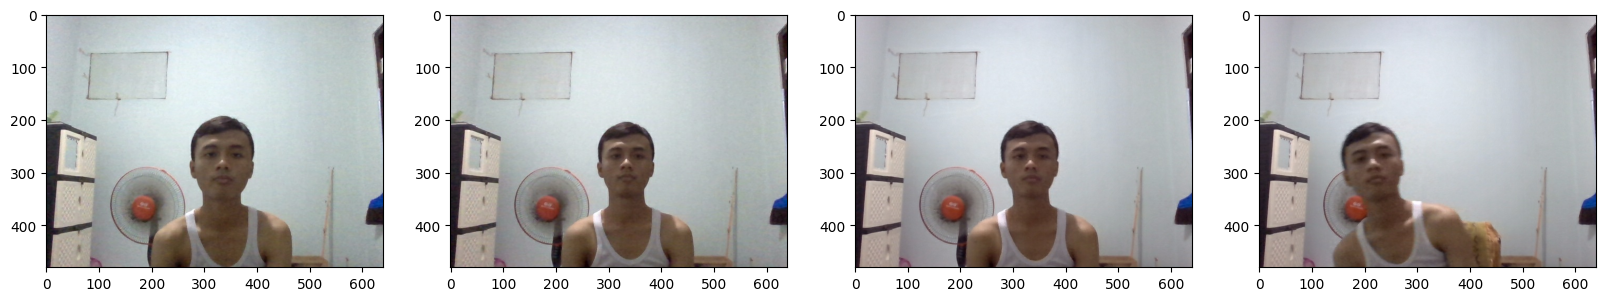

In [17]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))

for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

## 3. Partition Unaugmented Data

### 3.1 Manually Split Data into Train, Val, and Test

### 3.2 Move the Matching Labels

In [18]:
for folder in ["train", "val", "test"]:
    for file in os.listdir(os.path.join("data", folder, "images")):
        filename = file.split(".")[0]+".json"
        existing_filepath = os.path.join("data", "labels", filename)

        if os.path.exists(existing_filepath):
            new_filepath = os.path.join("data", folder, "labels", filename)
            os.replace(existing_filepath, new_filepath)

## 4. Apply Image Augmentation on Images and Labels Using Albumentations

### 4.1 Setup Albumentations Transform

In [19]:
import albumentations as alb

In [20]:
augmentor = alb.Compose([
    alb.RandomCrop(width=450, height=450),
    alb.HorizontalFlip(p=0.5),
    alb.RandomBrightnessContrast(p=0.2),
    alb.RandomGamma(p=0.2),
    alb.RGBShift(p=0.2),
    alb.VerticalFlip(p=0.5)
], bbox_params=alb.BboxParams(format="albumentations", label_fields=["class_labels"]))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [21]:
img = cv2.imread(os.path.join("data", "train", "images", "1a0b66eb-06f5-11ef-bc14-bcf4d4125546.jpg"))

In [22]:
with open(os.path.join("data", "train", "labels", "1a0b66eb-06f5-11ef-bc14-bcf4d4125546.json"), "r") as f:
    label = json.load(f)

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [23]:
coords = [0,0,0,0]
coords[0] = label["shapes"][0]["points"][0][0]
coords[1] = label["shapes"][0]["points"][0][1]
coords[2] = label["shapes"][0]["points"][1][0]
coords[3] = label["shapes"][0]["points"][1][1]

In [24]:
coords

[161.70040485829963, 1.336032388663995, 443.0769230769231, 365.7085020242915]

In [25]:
coords = list(np.divide(coords, [640,480,640,480]))

In [26]:
coords

[0.2526568825910932,
 0.0027834008097166562,
 0.6923076923076923,
 0.7618927125506072]

### 4.4 Apply Augmentations and View Results

In [27]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=["face"])

In [28]:
augmented["bboxes"]

[(0.04822312190733252, 0.0, 0.6735042735042736, 0.752685560053981)]

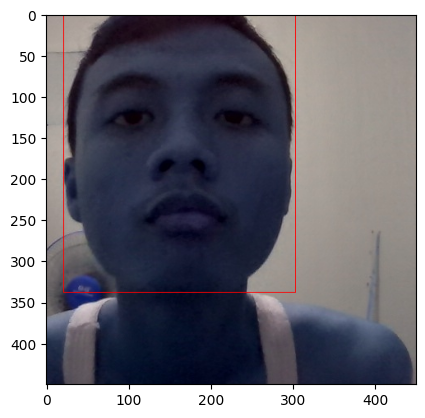

In [29]:
cv2.rectangle(
    augmented["image"],
    tuple(np.multiply(augmented["bboxes"][0][:2], [450,450]).astype(int)),
    tuple(np.multiply(augmented["bboxes"][0][2:], [450,450]).astype(int)),
    (255,0,0),
    1
)

plt.imshow(augmented["image"])

## 5. Build and Run Augmentation

### 5.1 Run Augmentation

In [31]:
for partition in ["train", "val", "test"]:
    for image in os.listdir(os.path.join("data", partition, "images")):
        img = cv2.imread(os.path.join("data", partition, "images", image))
        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join("data", partition, "labels", f"{image.split('.')[0]}.json")

        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                label = json.load(f)
                
            coords[0] = label["shapes"][0]["points"][0][0]
            coords[1] = label["shapes"][0]["points"][0][1]
            coords[2] = label["shapes"][0]["points"][1][0]
            coords[3] = label["shapes"][0]["points"][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=["face"])
                cv2.imwrite(os.path.join("aug_data", partition, "images", f"{image.split('.')[0]}.{x}.jpg"), augmented['image'])

                annotation = {}
                annotation["image"] = image

                if os.path.exists(label_path):
                    if len(augmented["bboxes"]) == 0:
                        annotation["bbox"] = [0,0,0,0]
                        annotation["class"] = 0
                    else:
                        annotation["bbox"] = augmented["bboxes"][0]
                        annotation["class"] = 1
                else:
                    annotation["bbox"] = [0,0,0,0]
                    annotation["class"] = 0

                with open(os.path.join("aug_data", partition, "labels", f"{image.split('.')[0]}.{x}.json"), "w") as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

### 5.2 Load Augmented Images to TensorFlow Dataset

In [32]:
train_images = tf.data.Dataset.list_files("aug_data\\train\images\\*.jpg", shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [33]:
val_images = tf.data.Dataset.list_files("aug_data\\val\images\\*.jpg", shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [34]:
test_images = tf.data.Dataset.list_files("aug_data\\test\images\\*.jpg", shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

## 6. Prepare Labels

### 6.1 Build Label Loading Function

In [35]:
def load_labels(label_path):
    with open(label_path.numpy(), "r", encoding="utf-8") as f:
        label = json.load(f)

    return[label["class"]], label["bbox"]

### 6.2 Load Labels to TensorFlow Dataset

In [36]:
train_labels = tf.data.Dataset.list_files("aug_data\\train\labels\\*.json", shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [37]:
val_labels = tf.data.Dataset.list_files("aug_data\\val\labels\\*.json", shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [38]:
test_labels = tf.data.Dataset.list_files("aug_data\\test\labels\\*.json", shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

## 7. Combine Label and Image Samples

### 7.1 Check Partition Lenghts

In [39]:
len (train_images), len (train_labels), len (val_images), len (val_labels), len (test_images), len (test_labels)

(3780, 3780, 780, 780, 840, 840)

### 7.2 Create Final Dataset (Images/Labels)

In [40]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [41]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1300)
val = val.batch(8)
val = val.prefetch(4)

In [42]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1000)
test = test.batch(8)
test = test.prefetch(4)

### 7.3 View Images and Annotations

In [43]:
data_samples = train.as_numpy_iterator()

In [44]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


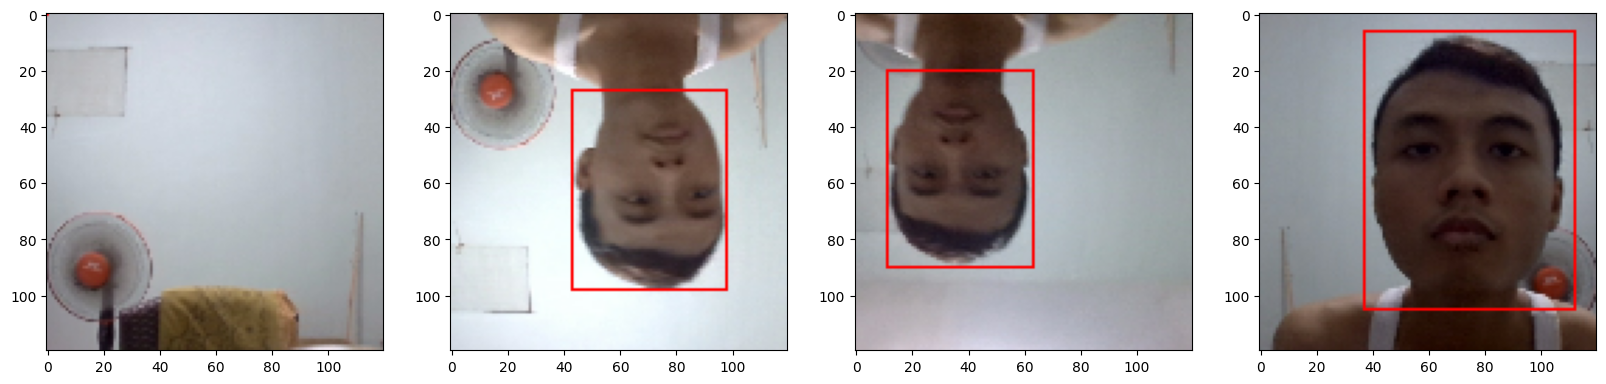

In [45]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))

for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    image_to_draw = sample_image.copy()

    cv2.rectangle(
        image_to_draw,
        tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
        tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
        (255,0,0),
        1
    )
    
    ax[idx].imshow(image_to_draw)

## 8. Build Deep Learning Using the Functional API

### 8.1 Import Layers and Base Network

In [46]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [47]:
vgg = VGG16(include_top=False)

In [48]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build Instance of Network

In [49]:
def build_model():
    input_layer = Input(shape=(120,120,3))

    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation="relu")(f1)
    class2 = Dense(1, activation="sigmoid")(class1)
    
    # Bounding Box Model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation="relu")(f2)
    regress2 = Dense(4, activation="sigmoid")(regress1)

    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [50]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.3816, 0.2744, 0.867 , 0.8887],
        [0.    , 0.    , 0.    , 0.    ],
        [0.1058, 0.4717, 0.5205, 1.    ],
        [0.788 , 0.1439, 1.    , 0.708 ],
        [0.    , 0.1703, 0.2   , 0.7227],
        [0.    , 0.272 , 0.144 , 1.    ],
        [0.321 , 0.3884, 0.579 , 0.72  ],
        [0.3726, 0.4373, 0.806 , 1.    ]], dtype=float16))

### 8.4 Test Out Neural Network

In [51]:
facetracker = build_model()

In [52]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [53]:
X, y = train.as_numpy_iterator().next()

In [54]:
X.shape

(8, 120, 120, 3)

In [55]:
classes, coords = facetracker.predict(X)

In [56]:
classes, coords

(array([[0.4233903 ],
        [0.44229937],
        [0.47946256],
        [0.45881218],
        [0.46080974],
        [0.40296835],
        [0.4338692 ],
        [0.38164872]], dtype=float32),
 array([[0.50946814, 0.49818313, 0.35306707, 0.52796084],
        [0.53446084, 0.49942458, 0.35391185, 0.6002043 ],
        [0.43694273, 0.52197844, 0.31023115, 0.4294694 ],
        [0.50065404, 0.5082981 , 0.43990156, 0.57842225],
        [0.45778885, 0.50052106, 0.27677384, 0.5398277 ],
        [0.5006635 , 0.49731195, 0.26902378, 0.48614708],
        [0.4423544 , 0.54127854, 0.30569145, 0.5016507 ],
        [0.47195306, 0.49436718, 0.37256163, 0.5594085 ]], dtype=float32))

## 9. Define Losses and Optimizer

### 9.1 Define Optimizer and LR

In [57]:
len(train)

473

In [58]:
batches_per_epoch = len(train)
lr_decay = (1./0.75-1)/batches_per_epoch # Seberapa banyak learning rate drop setiap kali setelah 1x epoch

In [59]:
lr_decay

0.0007047216349541929

In [60]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [61]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_predict = yhat[:,3] - yhat[:,1]
    w_predict = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_predict) + tf.square(h_true - h_predict))

    return delta_coord + delta_size

In [62]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test Out Loss Metrics

In [63]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.7667875>

In [64]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7847817>

In [65]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.7667875>

## 10. Train Neural Network

### 10.1 Create Custom Model Class

In [76]:
class FaceTracker(Model):
    def __init__(self, eyetracker, **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs):
        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)

            y_class = tf.reshape(y[0], (-1, 1))  # Reshape to (batch_size, 1)
            batch_classloss = self.closs(y_class, classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss + 0.5 * batch_classloss

            grad = tape.gradient(total_loss, self.model.trainable_variables)

        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training=False)

        batch_classloss = self.closs(y[0], classes)
        batch_regressloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_regressloss + 0.5 * batch_classloss

        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_regressloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [77]:
model = FaceTracker(facetracker)

In [78]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [79]:
logdir = "logs"

In [80]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [81]:
hist = model.fit(train, epochs=40, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/40
473/473 [==============================] - 26s 46ms/step - total_loss: 0.2025 - class_loss: 0.0692 - regress_loss: 0.1679 - val_total_loss: 0.0948 - val_class_loss: 0.0485 - val_regress_loss: 0.0705
Epoch 2/40
473/473 [==============================] - 24s 45ms/step - total_loss: 0.1234 - class_loss: 0.0400 - regress_loss: 0.1035 - val_total_loss: 0.0184 - val_class_loss: 6.5166e-04 - val_regress_loss: 0.0181
Epoch 3/40
473/473 [==============================] - 25s 45ms/step - total_loss: 0.0701 - class_loss: 0.0268 - regress_loss: 0.0566 - val_total_loss: 0.0248 - val_class_loss: 0.0018 - val_regress_loss: 0.0240
Epoch 4/40
473/473 [==============================] - 24s 46ms/step - total_loss: 0.0569 - class_loss: 0.0182 - regress_loss: 0.0479 - val_total_loss: 0.0070 - val_class_loss: 8.8249e-05 - val_regress_loss: 0.0069
Epoch 5/40
473/473 [==============================] - 24s 46ms/step - total_loss: 0.0412 - class_loss: 0.0122 - regress_loss: 0.0351 - val_total_loss: 0

### 10.3 Plot Performance

In [83]:
hist.history

{'total_loss': [0.049824364483356476,
  0.006560781970620155,
  0.005310442764312029,
  0.01944248005747795,
  0.0030177910812199116,
  0.013130486011505127,
  0.003008764237165451,
  0.003220546757802367,
  0.0012856894172728062,
  0.01713605225086212,
  0.0018783563282340765,
  0.005610797554254532,
  0.001959145301952958,
  0.000550829921849072,
  0.0018034183885902166,
  0.0011351682478561997,
  0.0043885610066354275,
  0.001378833083435893,
  0.0014567760517820716,
  0.0006844032905064523,
  0.0005413826438598335,
  0.0015075026312842965,
  0.00035080264206044376,
  0.0004125765699427575,
  0.000701323093380779,
  0.0027868261095136404,
  0.0009941983735188842,
  0.00020302138000261039,
  0.0005113313090987504,
  0.00012817526294384152,
  0.0010751825757324696,
  0.0007568912114948034,
  0.0007594966446049511,
  0.00025555293541401625,
  0.00022102460206951946,
  0.0006581980269402266,
  0.00041159274405799806,
  0.00011328669643262401,
  0.00031272132764570415,
  0.00106425967533

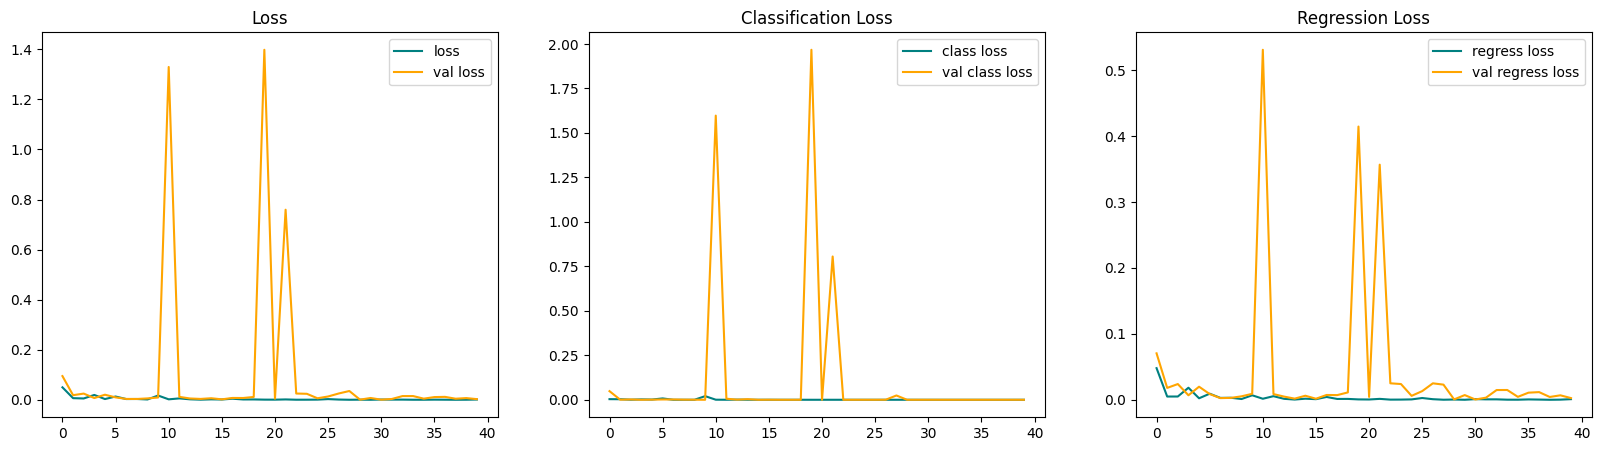

In [84]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history["total_loss"], color="teal", label="loss")
ax[0].plot(hist.history["val_total_loss"], color="orange", label="val loss")
ax[0].title.set_text("Loss")
ax[0].legend()

ax[1].plot(hist.history["class_loss"], color="teal", label="class loss")
ax[1].plot(hist.history["val_class_loss"], color="orange", label="val class loss")
ax[1].title.set_text("Classification Loss")
ax[1].legend()

ax[2].plot(hist.history["regress_loss"], color="teal", label="regress loss")
ax[2].plot(hist.history["val_regress_loss"], color="orange", label="val regress loss")
ax[2].title.set_text("Regression Loss")
ax[2].legend()

plt.show()

## 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [89]:
test_data = test.as_numpy_iterator()

In [109]:
test_sample = test_data.next()

In [110]:
yhat = facetracker.predict(test_sample[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


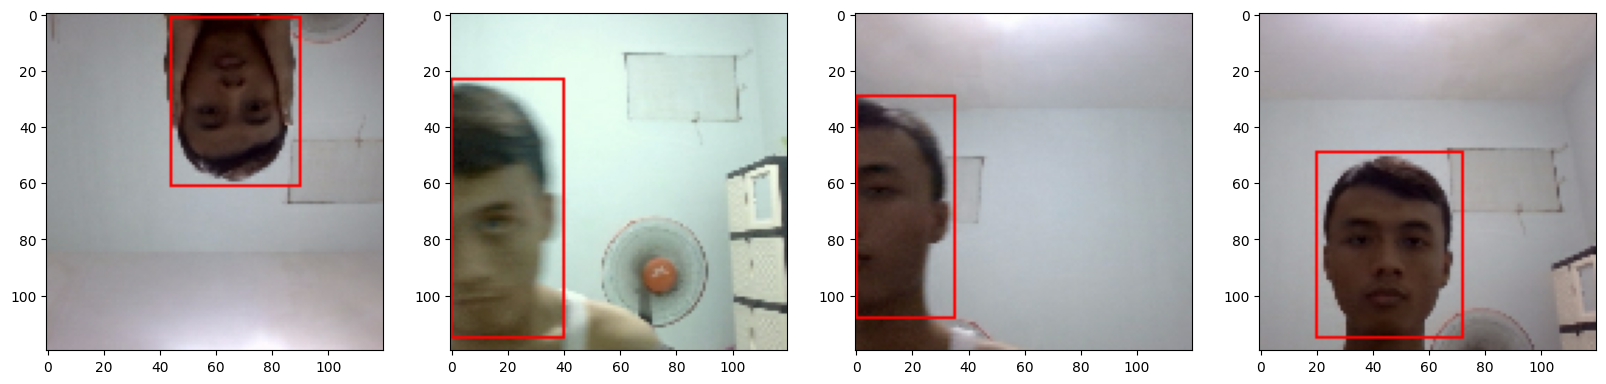

In [111]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))

for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    image_to_draw = sample_image.copy()

    if yhat[0][idx] > 0.7:
        cv2.rectangle(
            image_to_draw,
            tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
            tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
            (255, 0, 0),
            1,
        )

    ax[idx].imshow(image_to_draw)

### 11.2 Save the Model

In [1]:
from tensorflow.keras.models import load_model

In [113]:
facetracker.save("facetracker.h5")

In [2]:
facetracker = load_model("facetracker.h5")

### 11.3 Real Time Detection

In [3]:
import cv2
import numpy as np
import tensorflow as tf

In [4]:
cap = cv2.VideoCapture(0)

while cap.isOpened():
    _, frame = cap.read()
    frame = frame[50:500, 50:500, :]

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120, 120))

    yhat = facetracker.predict(np.expand_dims(resized / 255, 0))
    sample_coords = yhat[1][0]

    if yhat[0] > 0.7:
        # Controls the Main Rectangle
        cv2.rectangle(
            frame,
            tuple(np.multiply(sample_coords[:2], [450, 450]).astype(int)),
            tuple(np.multiply(sample_coords[2:], [450, 450]).astype(int)),
            (255, 0, 0),
            1,
        )

        # Controls the Label Rectangle
        cv2.rectangle(
            frame,
            tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int), [0, -30])),
            tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int), [80, 0])),
            (255, 0, 0),
            -1,
        )

        # Controls the Text Rendered
        cv2.putText(
            frame,
            "Face",
            tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int), [0, -5])),
            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1, cv2.LINE_AA
        )

    cv2.imshow("EyeTrack", frame)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()